## Corners and Lines(10pts)
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez, Paola Cascante, Ziyan Yang - (vicente@virginia.edu)</em><br/><br/>

In this lab we will apply our knowledge in the lectures in order to find corners and lines in images.



### 1. Detecting Corners (5pts).
In this section we will implement a version of the Harris Corner Detection. You are going to detect the corners in UVA Rotunda. Note that you are not allowed to use any outside library other than the ones explicitly indicated for this question. The idea is for you to implement the Harris corner detector and a variant of it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import imageio

# Download the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~pc9za/rotunda-lg.jpg'
img = imageio.imread(img_url)

# Please attention, in this assignment image is floating point.
img = img.astype('float') / 255.0
print(img.shape)
# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img); plt.grid(False);plt.axis('off');plt.show()
  
display_image(img)

(365, 700, 3)


<Figure size 640x480 with 1 Axes>

#### 1.1  Computing $I_x^2$, $I_y^2$ and $I_xI_y$ [1pts]
Compute and display $I_x^2$, $I_y^2$, and $I_xI_y$ using Sobel operators. You are only allowed to use scipy.signal.convolve2d for any convolutional operations. Feel free to reuse your code from the previous assignment.

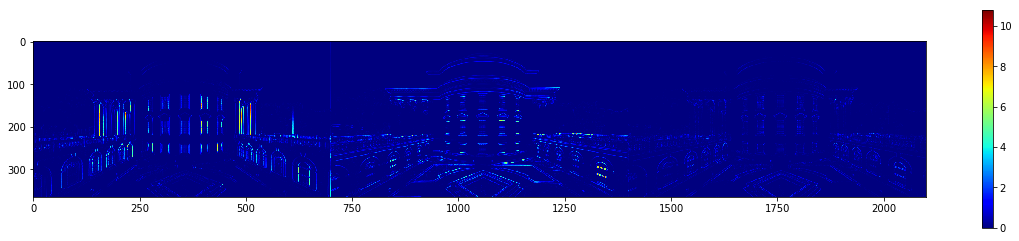

In [3]:
from scipy import signal
# Compute Ixx, Iyy and Ixy here.
# Convert the image into gray scale
img_2 = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
sobel_vertical = np.array([[1, 0,  -1],
                    [2, 0, -2],
                    [1, 0,  -1]])
sobel_horizontal = np.array([[1, 2, 1],
                    [0, 0, 0], 
                    [-1, -2, -1]])

magnitude_map_vertical = signal.convolve2d(img_2, sobel_vertical, mode='same', boundary='fill', fillvalue=0)
magnitude_map_horizontal = signal.convolve2d(img_2, sobel_horizontal, mode='same', boundary='fill', fillvalue=0)

Iyy = magnitude_map_horizontal * magnitude_map_horizontal
Ixx = magnitude_map_vertical * magnitude_map_vertical
Ixy = np.sqrt(magnitude_map_vertical ** 2) * np.sqrt(magnitude_map_horizontal ** 2)
Ixy = magnitude_map_vertical * magnitude_map_horizontal

# Plot Ixx, Iyy, Ixy.
plt.figure(figsize=(20,4))
plt.imshow(np.concatenate((Ixx, Iyy, np.abs(Ixy)), axis = 1), 
           cmap =  'jet')
plt.colorbar()
plt.grid(False)
plt.show()

####1.2 Compute the response map R using the Harris criteria and the Szeliski criteria [2pts].
Show side by side the input image with the response map R computed using the original Harris detector with $\alpha=0.05$, and using the Harmonic mean formula proposed by Szeliski. Use a window/patch size of 12x12 to define the momentum matrix M.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


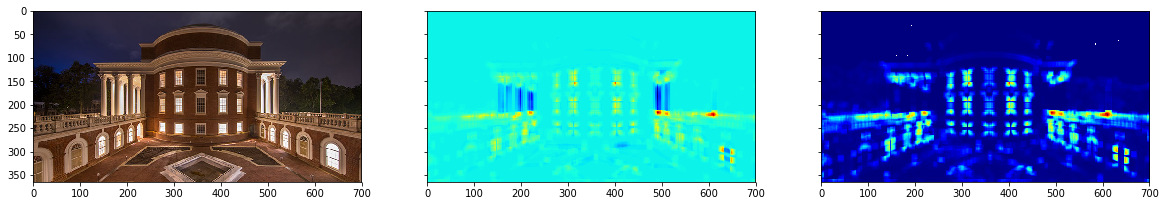

In [95]:
# Compute the Rmap and RHarmonicMap map responses.
a = 0.05

img_2 = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
add_mask = np.ones((12, 12))

Sxx = signal.convolve2d(Ixx, add_mask, mode='same', boundary='fill', fillvalue=0)
Syy = signal.convolve2d(Iyy, add_mask, mode='same', boundary='fill', fillvalue=0)
Sxy = signal.convolve2d(Ixy, add_mask, mode='same', boundary='fill', fillvalue=0)

det = Sxx * Syy - Sxy ** 2
trace = Sxx + Syy 
RMap = det - a * trace ** 2
RHarmonicMap = det / trace

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 4))
ax1.imshow(img);ax1.grid('off')
ax2.imshow(RMap, cmap = 'jet'); ax2.grid('off')
ax3.imshow(RHarmonicMap, cmap ='jet'); ax3.grid('off');

####1.3 Non-max Supression and Final Output [2pts]

Perform non-max supression on the outputs obtained in the previous step so that you get a list of pixels corresponding to corners for each method. Feel free to use any  method you can think of but the general idea is to leave only one point per corner and no two points with high values should be together. An easy way is to just define a minimum distance between corners of 5 pixels. The only pixels surviving (non-zero) after non-max should be the ones that a) pass a threshold (which you are free to define), and b) are the maximum pixel within their neighborhood. I am including outputs as an example of what it should more or less look like at the end.

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


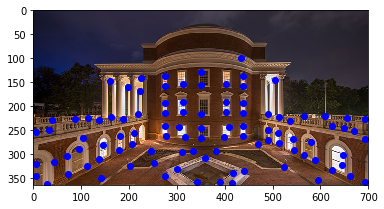

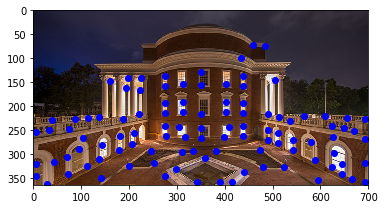

In [99]:
def nonmax(RMap, threshold):
  # Non-max supression and thresholding function.
    row_max, col_max = RMap.shape
    Rmap_max = np.zeros(RMap.shape)
    for r in range(row_max): 
      for c in range(col_max): 
        if r - 20 >= 0: 
          rs = r - 20
        else: 
          rs = 0
        if c - 20 >= 0: 
          cs = c - 20
        else: 
          cs = 0
        if r + 20 < row_max: 
          re = r + 20
        else: 
          re = row_max - 1
        if c + 20 < col_max: 
          ce = c + 20
        else: 
          ce = col_max - 1
        vmax = np.amax(RMap[rs:re+1, cs:ce+1])
        if RMap[r][c] != vmax or RMap[r][c] < threshold:
          RMap[r][c] = 0
    return RMap

# np.nonzero extracts 2d coordinates of non-zero elements.
ys1, xs1 = np.nonzero(nonmax(RMap, 200))
ys2, xs2 = np.nonzero(nonmax(RHarmonicMap, 5))

# Method 1: Harris operator original score.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs1, ys1, '.b', markersize=12)
ax.grid('off')

# Method 2: Szeliski's Harmonic mean.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs2, ys2, '.b', markersize=12)
ax.grid('off')

**Final Comments:** What happens if you rotate the image? Will it still detect the same corners? What happens if you resize the image? Will it detect the same corners? When will you get more corners detected, if you resize up or resize down the image?

### 2. Detecting Lines (5pts).
In this section we will perform line detection by implementing the Hough Transform.

Image size:  (800, 1200, 3)


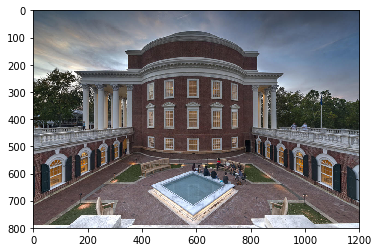

In [75]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import imageio
from urllib.request import urlopen

# Download the image in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~pc9za/rotunda-lg2.jpg'
img = imageio.imread(img_url)
img = img.astype('float') / 255

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  
display_image(img)

#### 2.1 Hough Transform [2pts]

Use the Hough Transform to find all the lines in the image. Show the Hough Transform for the UVA Rotunda image.

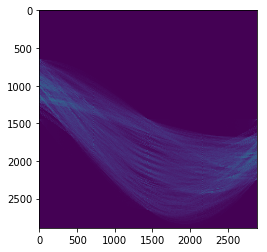

In [61]:
# Your code goes here.
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r * 255 + 0.5870 * g * 255 + 0.1140 * b * 255
    return gray

gs = rgb2gray(img)
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

Ix = signal.convolve2d(gs, sobel_x, mode='same', boundary='fill', fillvalue=0)
Iy = signal.convolve2d(gs, sobel_y, mode='same', boundary='fill', fillvalue=0)

Ixx = Ix ** 2
Iyy = Iy ** 2
edge_img = np.sqrt(Ixx ** 2 + Iyy ** 2)
threshold = 14990
edge_img[edge_img < threshold] = 0
edge_img[edge_img >= threshold] = 1

rows, cols = edge_img.shape

max_rho = np.sqrt(rows ** 2 + cols ** 2)
total_steps = int(max_rho) * 2 + 1

all_theta = np.linspace(-90.0, 90.0, total_steps)
res = 1
min_rho = -np.ceil(max_rho/res)*res
max_rho = -min_rho
num_rho = int((max_rho - min_rho) / res) + 1
all_rho = np.linspace(min_rho, max_rho, num_rho)

hough_space = np.zeros((len(all_rho), len(all_theta)))

for i in range(rows):
      for j in range(cols):
          if edge_img[i, j] != 0:
              for k in range(len(all_theta)):
                  rho = j*np.cos(all_theta[k]*np.pi/180.0) + i*np.sin(all_theta[k]*np.pi/180)
                  rho_index = int(np.ceil((rho - min_rho)/res))
                  hough_space[rho_index, k] += 1

plt.imshow(hough_space)

#### 2.2 Line Detection [3pts]
Find the peaks in the Hough Transform computed in the previous step and plot the original images with red lines overlaid showing the detected lines.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


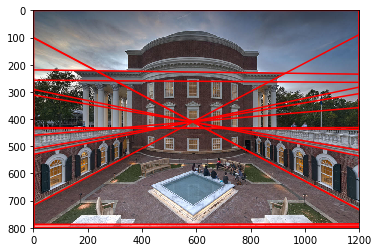

In [76]:
# Your code goes here.
hough2 = np.copy(hough_space)
threshold = 340
hough_max = ndimage.maximum_filter(hough2, (20, 30))
hough2 = (hough_space == hough_max)

hough_min = ndimage.minimum_filter(hough_space, (20, 30))
diff = ((hough_max - hough_min) > threshold)
hough2[diff == 0] = 0

plt.imshow(img)

x = np.linspace(0.0,img.shape[1],img.shape[1])

for r in range(len(hough2)):
  for t in range(len(hough2[0])):
    if hough2[r][t]:
      rho = min_rho + res * r 
      theta = -90.0 + t*180/num_rho
      theta *= np.pi/180.0
      if np.sin(theta) != 0:
        k = -np.cos(theta) / np.sin(theta)
        b = rho / np.sin(theta)
        plt.plot(x, k*x+b,'-r')
      else:
        plt.axvline(x=rho, color="r")
plt.ylim(ymax=0, ymin=800)
plt.xlim(xmax=1200)

plt.show()

**Final Comments:** The Hough Transform detects lines, how would you modify the algorithm to find instead line segments? 